In [4]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Create the image generators for train, validation, and test
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Load images from directories using flow_from_directory
train_data_gen = train_image_generator.flow_from_directory(
    'cats_and_dogs/train',  # Path to training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images to this size
    batch_size=128,
    class_mode='binary'  # Binary classification (cat or dog)
)

validation_data_gen = validation_image_generator.flow_from_directory(
    'cats_and_dogs/validation',  # Path to validation data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=128,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    'cats_and_dogs/test',  # Path to test data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=128,
    class_mode=None,  # No labels for test data
    shuffle=False  # Important to keep test data in the same order
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


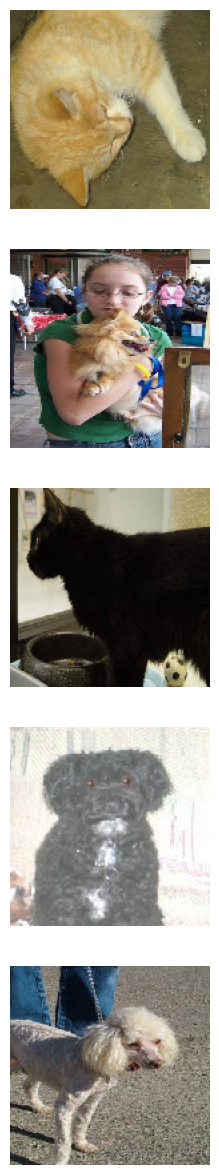

In [7]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Found 2000 images belonging to 2 classes.


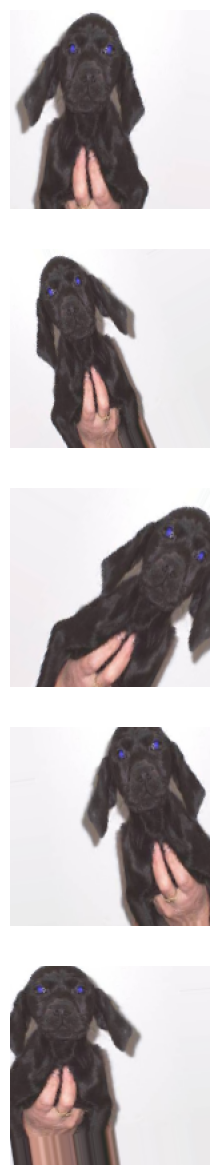

In [8]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'  # Fill pixels after transformation
)

# Create the data generators
train_data_gen = train_image_generator.flow_from_directory(
    'cats_and_dogs/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=128,
    class_mode='binary'
)

# Plot augmented images
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


Found 2000 images belonging to 2 classes.


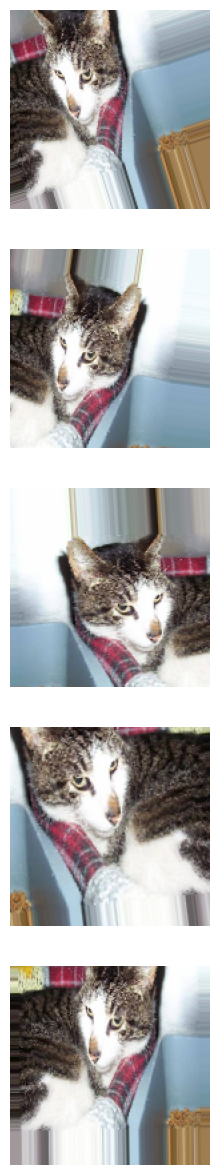

In [9]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [12]:
from tensorflow.keras import layers, models

model = models.Sequential()

# Add convolutional layers with ReLU activation and MaxPooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(layers.Flatten())

# Add a fully connected (dense) layer
model.add(layers.Dense(512, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_data_gen,  # Training data generator
    steps_per_epoch=10,  # Number of batches per epoch (adjust as needed)
    epochs=5,  # Number of epochs
    validation_data=validation_data_gen,  # Validation data generator
    validation_steps=5  # Number of validation steps
)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 9s/step - accuracy: 0.5032 - loss: 1.0569 - val_accuracy: 0.5172 - val_loss: 0.6881
Epoch 2/5
 6/10 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.5027 - loss: 0.6936

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5011 - loss: 0.6937 - val_accuracy: 0.4972 - val_loss: 0.6896
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.4962 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6771
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.5407 - loss: 0.6844 - val_accuracy: 0.5306 - val_loss: 0.6683
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.5306 - loss: 0.6869 - val_accuracy: 0.4969 - val_loss: 0.6905


ValueError: x and y must have same first dimension, but have shapes (15,) and (5,)

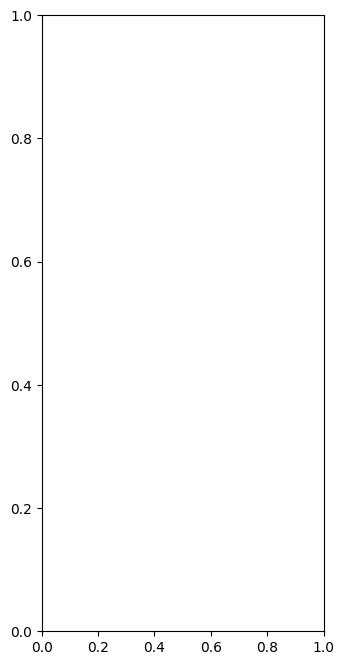

In [14]:
import matplotlib.pyplot as plt

# Get accuracy and loss values from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

# Plot accuracy and loss
plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [15]:
# Predict on the test data
predictions = model.predict(test_data_gen)

# Convert predictions to binary values: 0 (cat) or 1 (dog)
probabilities = (predictions > 0.5).astype(int)

# Plot test images and their predicted labels
plotImages(test_data_gen, probabilities)


ValueError: Must provide at least one structure

In [16]:
# Assuming you have predefined correct answers in the `answers` list:
answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]

correct = 0
for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100
passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get


SyntaxError: unterminated string literal (detected at line 17) (<ipython-input-16-71881690801f>, line 17)